# Interpretability Analysis for Legal NER

This notebook explores interpretability for a Portuguese legal-domain NER model (BERT fine-tuned on LeNER-Br). We focus on how the model attends to tokens and which inputs drive its predictions, using attention visualization and gradient-based attributions.

## 1. Introduction
- Interpretability in Transformer-based NER asks *which parts of the input* influence entity predictions and *how* the model combines context.
- Model: Portuguese BERT fine-tuned on LeNER-Br (same checkpoint as in previous stages).
- Objective: inspect decision patterns via attention maps, saliency/occlusion attributions, and a dataset-level EntityFocus@k metric that quantifies focus on entity tokens.


## 2. Setup and Model Loading

In [78]:
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoModelForTokenClassification, AutoTokenizer

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [79]:
# Load dataset (only a subset is needed for qualitative examples)
dataset_id = "peluz/lener_br"
hf_token = os.getenv("HF_TOKEN")
lener = load_dataset(dataset_id, token=hf_token, trust_remote_code=True)

ner_feature = lener["train"].features["ner_tags"]
label_list = ner_feature.feature.names
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}

val_subset = lener["validation"].select(range(50))  # small slice for exploration
print(val_subset)
print("Labels:", label_list)


Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 50
})
Labels: ['O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'B-PESSOA', 'I-PESSOA', 'B-TEMPO', 'I-TEMPO', 'B-LOCAL', 'I-LOCAL', 'B-LEGISLACAO', 'I-LEGISLACAO', 'B-JURISPRUDENCIA', 'I-JURISPRUDENCIA']


In [80]:
# Load fine-tuned model and tokenizer with attention outputs enabled

model_dir = r"C:\Users\diogo\Repositorios\ner_smalllm_project\notebooks\models\lenerbr_bert_base"

tokenizer = AutoTokenizer.from_pretrained(model_dir)


model = AutoModelForTokenClassification.from_pretrained(
    model_dir,
    output_attentions=True,
)
model.config.id2label = id2label
model.config.label2id = label2id
model.to(device)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_dir)

## 3. Utility Functions
We define helper utilities for prediction, example selection, and formatted display. All functions operate on pre-split word tokens to keep alignment with the dataset.

In [81]:
@torch.no_grad()
def ner_predict(tokens, model, tokenizer, label_list, max_length=256):
    enc = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    )
    word_ids = enc.word_ids()
    enc = {k: v.to(device) for k, v in enc.items()}

    out = model(**enc)
    pred_ids = out.logits.argmax(-1).squeeze(0).detach().cpu().numpy()

    preds, seen = [], set()
    for pos, wid in enumerate(word_ids):
        if wid is None or wid in seen:
            continue
        seen.add(wid)
        preds.append(label_list[int(pred_ids[pos])])
    return preds


def print_tokens_with_labels(tokens, labels):
    """Pretty-print tokens and their labels side by side."""
    for t, l in zip(tokens, labels):
        print(f"{t:<20} {l}")

## 4. Qualitative illustration: attention visualization
We inspect attention heads on a single validation example to see how the model distributes focus across tokens. This is for intuition-building only; dataset-level evidence follows below.


In [82]:
def attention_to_word_level(attn, word_ids, tokens, agg="mean"):
    spans, word_indices = get_word_spans(word_ids)
    n_words = len(word_indices)

    word_attn = np.zeros((n_words, n_words), dtype=float)

    for i, wi in enumerate(word_indices):
        pos_i = spans[wi]
        for j, wj in enumerate(word_indices):
            pos_j = spans[wj]
            block = attn[np.ix_(pos_i, pos_j)]
            if agg == "mean":
                word_attn[i, j] = block.mean()
            elif agg == "max":
                word_attn[i, j] = block.max()
            else:
                raise ValueError(f"Unknown agg='{agg}'")

    word_labels = [tokens[w] for w in word_indices]
    return word_attn, word_labels


def get_word_spans(word_ids):
    """Return mapping word_id -> [subtoken positions] and the ordered word indices."""
    spans = defaultdict(list)
    for pos, wid in enumerate(word_ids):
        if wid is not None:
            spans[wid].append(pos)

    word_indices = sorted(spans.keys())
    return spans, word_indices


def get_word_positions(word_ids):
    """Return the first subtoken position for each word in order."""
    first_pos = {}
    for i, wid in enumerate(word_ids):
        if wid is not None and wid not in first_pos:
            first_pos[wid] = i
    word_indices = sorted(first_pos.keys())
    positions = [first_pos[w] for w in word_indices]
    return word_indices, positions


def plot_attention_head_word_level(
    tokens, encoding, attentions, layer, head, title=None
):
    attn = attentions[layer][0, head].detach().cpu().numpy()
    word_ids = encoding.word_ids()

    word_attn, word_labels = attention_to_word_level(attn, word_ids, tokens, agg="mean")

    plt.figure(figsize=(6, 5))
    plt.imshow(word_attn, cmap="viridis")
    plt.colorbar(label="Attention weight")
    plt.xticks(range(len(word_labels)), word_labels, rotation=60, ha="right")
    plt.yticks(range(len(word_labels)), word_labels)
    plt.title(title or f"Layer {layer}, head {head} (word-level)")
    plt.tight_layout()
    plt.show()


def plot_last_layer_average_word_level(tokens, encoding, attentions, title=None):
    last = attentions[-1][0].mean(0).detach().cpu().numpy()
    word_ids = encoding.word_ids()

    word_indices, positions = get_word_positions(word_ids)
    attn_words = last[np.ix_(positions, positions)]
    labels = [tokens[w] for w in word_indices]

    plt.figure(figsize=(6, 5))
    plt.imshow(attn_words, cmap="viridis")
    plt.colorbar(label="Average attention")
    plt.xticks(range(len(labels)), labels, rotation=60, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.title(title or "Last layer average attention (word-level)")
    plt.tight_layout()
    plt.show()


def plot_query_attention_word_level_by_token(
    tokens, encoding, attentions, layer, head, query_token, occurrence=0
):
    """Plot attention weights from a specific token occurrence to all words."""
    matches = [i for i, t in enumerate(tokens) if t == query_token]
    if not matches:
        raise ValueError(f"Token '{query_token}' not found in tokens.")
    if occurrence >= len(matches):
        raise ValueError(
            f"Token '{query_token}' has only {len(matches)} occurrences; occurrence={occurrence} invalid."
        )

    query_word_idx = matches[occurrence]

    word_ids = encoding.word_ids()
    attn = attentions[layer][0, head].detach().cpu().numpy()

    word_attn, word_labels = attention_to_word_level(attn, word_ids, tokens, agg="mean")
    weights = word_attn[query_word_idx]

    plt.figure(figsize=(10, 3))
    plt.bar(range(len(word_labels)), weights)
    plt.xticks(range(len(word_labels)), word_labels, rotation=60, ha="right")
    plt.title(f"Word-level attention from '{query_token}' (layer {layer}, head {head})")
    plt.ylabel("Attention weight")
    plt.tight_layout()
    plt.show()


13 11
Tokens and predicted labels:
Brasilia             B-LOCAL
(                    I-LOCAL
DF                   I-LOCAL
)                    I-LOCAL
,                    O
15                   B-TEMPO
de                   I-TEMPO
Março                I-TEMPO
de                   I-TEMPO
2018                 I-TEMPO
.                    O


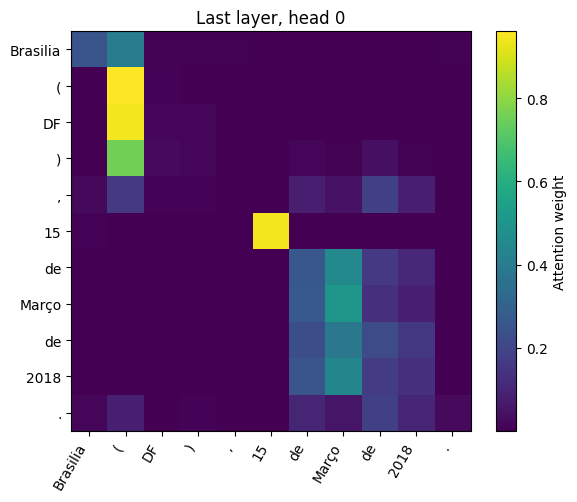

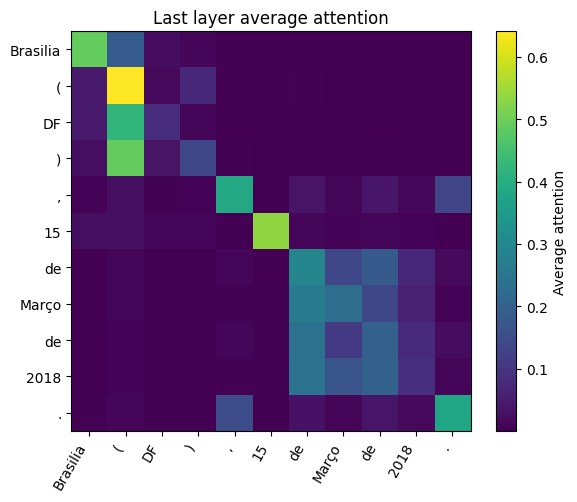

In [83]:
# Select an example index with varied legal entities (change example_idx if needed)
def find_short_example_with_entities(dataset, max_tokens=25):
    """
    Return (idx, tokens, tags) for the first example that:
    - has length <= max_tokens
    - has at least one entity tag != 0 ("O")
    """
    for i, ex in enumerate(dataset):
        tokens = ex["tokens"]
        tags = ex["ner_tags"]
        if len(tokens) <= max_tokens and any(t != 0 for t in tags):
            return i, tokens, tags
    return None, None, None


idx, example_tokens, example_tags = find_short_example_with_entities(
    val_subset, max_tokens=25
)
print(idx, len(example_tokens))

example_gold = [label_list[t] for t in example_tags]
example_preds = ner_predict(example_tokens, model, tokenizer, label_list)

print("Tokens and predicted labels:")
print_tokens_with_labels(example_tokens, example_preds)

# Forward pass with attentions
encoding = tokenizer(
    example_tokens,
    is_split_into_words=True,
    return_tensors="pt",
    truncation=True,
    max_length=256,
)
encoding_tensors = {k: v.to(device) for k, v in encoding.items()}
with torch.no_grad():
    outputs = model(**encoding_tensors)
attentions = outputs.attentions  # list length num_layers

plot_attention_head_word_level(
    example_tokens, encoding, attentions, layer=-1, head=0, title="Last layer, head 0"
)
plot_last_layer_average_word_level(
    example_tokens, encoding, attentions, title="Last layer average attention"
)

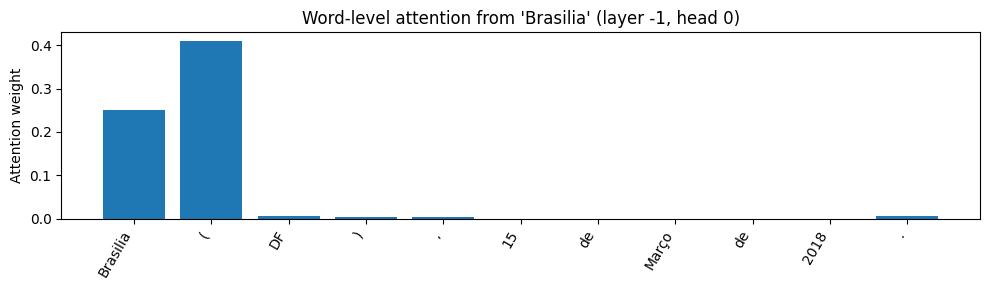

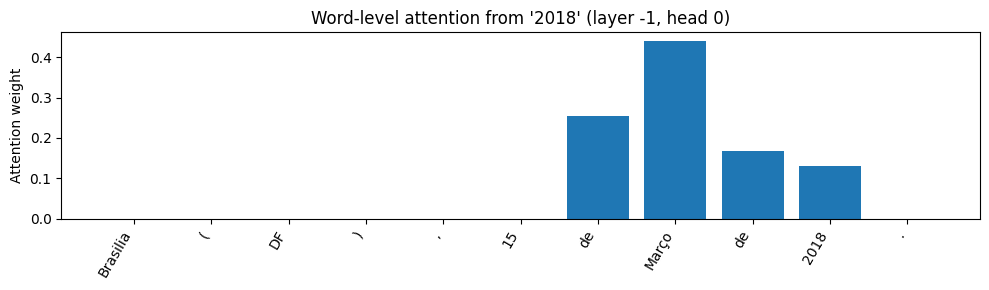

In [84]:
plot_query_attention_word_level_by_token(
    tokens=example_tokens,
    encoding=encoding,
    attentions=attentions,
    layer=-1,
    head=0,
    query_token="Brasilia",
)
plot_query_attention_word_level_by_token(
    tokens=example_tokens,
    encoding=encoding,
    attentions=attentions,
    layer=-1,
    head=0,
    query_token="2018",
)

### Qualitative attention commentary

The attention visualizations show that the model relies heavily on strong lexical anchors for entity prediction, such as location names (“Brasilia”, “DF”) and temporal expressions (“15”, “Março”, “2018”).

Query-based attention confirms that the model uses a narrow local context: entity tokens attend mostly to their neighbors and connective words (“de”, “do”).

This section is a qualitative illustration; see the EntityFocus@k section below for dataset-level evidence.


## 5. Gradient-Based Attribution (Saliency)
We compute saliency scores by backpropagating from the maximum logit to input embeddings. High absolute gradients suggest tokens the model deems important for its current predictions.

In [85]:
def saliency_importance(tokens, model, tokenizer, max_length=256):
    enc = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    )
    word_ids = enc.word_ids()
    enc = {k: v.to(device) for k, v in enc.items()}

    input_ids = enc.pop("input_ids")
    attention_mask = enc.get("attention_mask")

    emb_layer = model.get_input_embeddings()
    inputs_embeds = emb_layer(input_ids)
    inputs_embeds.retain_grad()

    out = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
    logits = out.logits  # (1, seq, num_labels)

    # alvo: soma dos logits das labels previstas em cada posição (word-level first subtoken)
    target_positions, target_label_ids = [], []
    seen = set()
    for pos, wid in enumerate(word_ids):
        if wid is None or wid in seen:
            continue
        seen.add(wid)
        target_positions.append(pos)
        target_label_ids.append(int(logits[0, pos].argmax().item()))

    target = logits[0, target_positions, target_label_ids].sum()
    model.zero_grad(set_to_none=True)
    target.backward()

    token_scores = (
        inputs_embeds.grad.abs().sum(dim=-1).squeeze(0).detach().cpu().numpy()
    )

    # volta para word-level (1 score por token original)
    word_scores, seen2 = [], set()
    for pos, wid in enumerate(word_ids):
        if wid is None or wid in seen2:
            continue
        seen2.add(wid)
        word_scores.append(float(token_scores[pos]))
    return word_scores


def plot_saliency(tokens, scores, title="Saliency per token"):
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(tokens)), scores, color="#4f81bd")
    plt.xticks(range(len(tokens)), tokens, rotation=60, ha="right")
    plt.ylabel("Importance (|grad| sum)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

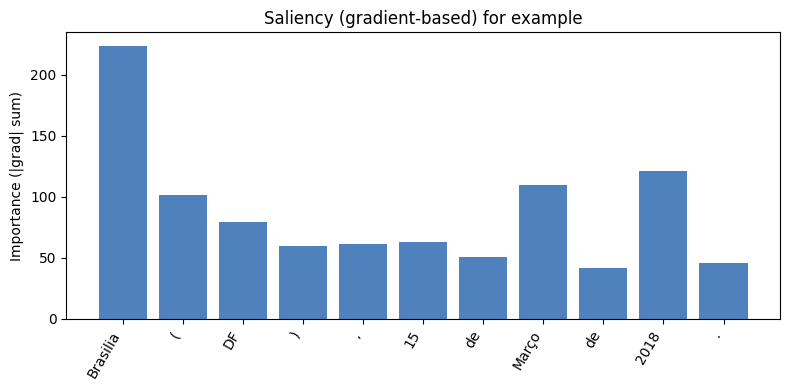

Top important tokens:
Brasilia        223.5783
2018            121.2237
Março           109.7941
(               101.1149
DF              79.6794


In [86]:
saliency_scores = saliency_importance(example_tokens, model, tokenizer)
plot_saliency(example_tokens, saliency_scores, title="Saliency (gradient-based) for example")

print("Top important tokens:")
for tok, score in sorted(zip(example_tokens, saliency_scores), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{tok:15s} {score:.4f}")


### Interpretation of our example results
In this example, tokens such as **“2018”**, **“Março”** and **“15”** receive the highest saliency scores, which aligns with their role in forming a complete temporal entity (B-TEMPO / I-TEMPO). Likewise, **“Brasília”** and **“DF”** also appear among the most influential tokens, reflecting the model’s reliance on these lexical anchors for predicting location entities.

This confirms, for this specific sentence, that the model focuses on semantically meaningful spans rather than arbitrary artifacts. Saliency highlights *causal sensitivity* rather than *information flow*: while attention shows where the model distributes information, saliency indicates which tokens drive the logits. Function words (“de”, “()”) show low saliency.

### Limitations
Gradient-based saliency can still highlight correlated tokens rather than truly causal ones. Non-linear interactions in the transformer can also dilute or exaggerate gradient signals. The dataset-level section below complements this single-example view.


## 6. Integrated Gradients
Integrated Gradients reduces gradient noise by integrating along a path from a baseline to the input. If `captum` is available, we compute token-level attributions and compare them to raw saliency.

In [87]:
try:
    from captum.attr import IntegratedGradients
    captum_available = True
    print("Captum available: running Integrated Gradients.")
except ImportError:
    captum_available = False
    print("Captum not installed; skipping Integrated Gradients. You can install captum to enable this section.")


Captum available: running Integrated Gradients.


In [88]:
def integrated_gradients_importance(tokens, model, tokenizer, steps=24):
    # Computes token-level attribution using Integrated Gradients (if captum is installed).
    if not captum_available:
        return None

    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=256,
    )
    word_ids = encoding.word_ids()
    encoding = {k: v.to(device) for k, v in encoding.items()}

    input_ids = encoding.pop("input_ids")
    attention_mask = encoding.get("attention_mask")

    embeddings_layer = model.get_input_embeddings()

    def forward(inputs_embeds):
        outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        # Max over labels and positions, then batch
        return outputs.logits.max(dim=-1).values.max(dim=-1).values

    ig = IntegratedGradients(forward)
    baseline = torch.zeros_like(embeddings_layer(input_ids))
    attributions, _ = ig.attribute(
        embeddings_layer(input_ids),
        baselines=baseline,
        n_steps=steps,
        return_convergence_delta=True,
    )

    token_attr = attributions.abs().sum(dim=-1).squeeze(0).detach().cpu().numpy()

    word_scores = []
    seen = set()
    for idx, word_id in enumerate(word_ids):
        if word_id is None or word_id in seen:
            continue
        seen.add(word_id)
        word_scores.append(token_attr[idx])
    return word_scores

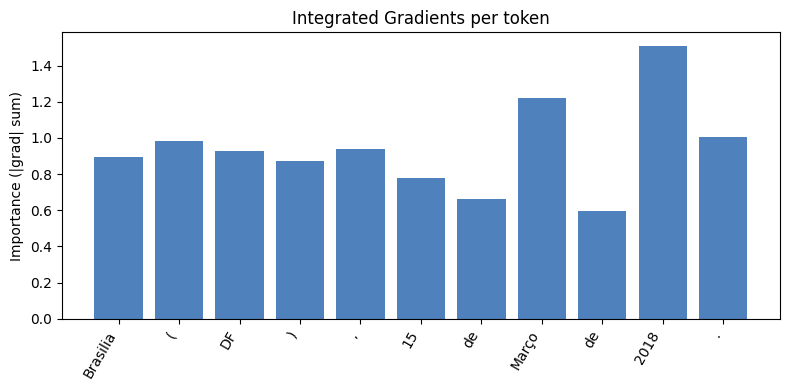

Top IG tokens:
2018            1.5080
Março           1.2209
.               1.0045
(               0.9816
,               0.9382


In [89]:
if captum_available:
    ig_scores = integrated_gradients_importance(example_tokens, model, tokenizer)
    if ig_scores is not None:
        plot_saliency(example_tokens, ig_scores, title="Integrated Gradients per token")
        print("Top IG tokens:")
        for tok, score in sorted(zip(example_tokens, ig_scores), key=lambda x: x[1], reverse=True)[:5]:
            print(f"{tok:15s} {score:.4f}")


### Interpretation — Integrated Gradients

Integrated Gradients provides a smoother and more reliable importance signal than raw saliency by accumulating gradient contributions along a path from a neutral baseline to the input.
In our qualitative example, the method also highlights 2018, Março, and punctuation adjacent to entity boundaries, showing a clear alignment with the tokens that carry the strongest semantic cues for the predicted entities (LOCAL and TEMPO).


## 7. Occlusion Sensitivity
Occlusion tests model reliance on each token by masking it and observing the change in sequence confidence.


In [90]:
def compute_occlusion_scores(tokens, model, tokenizer, label_list, return_tokens=True):
    """Compute token-level occlusion importances as score drops from masking."""

    def sequence_score(logits, word_ids):
        per_position = logits.max(dim=-1).values.squeeze(0)
        score = 0.0
        seen = set()
        for idx, word_id in enumerate(word_ids):
            if word_id is None or word_id in seen:
                continue
            seen.add(word_id)
            score += per_position[idx].item()
        return score

    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=256,
    )
    word_ids = encoding.word_ids()
    encoding = {k: v.to(device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)
    baseline_score = sequence_score(outputs.logits, word_ids)

    mask_token = tokenizer.mask_token if tokenizer.mask_token is not None else "___"
    importances = []

    for i in range(len(tokens)):
        occluded = list(tokens)
        occluded[i] = mask_token

        occluded_encoding = tokenizer(
            occluded,
            is_split_into_words=True,
            return_tensors="pt",
            truncation=True,
            max_length=256,
        )
        occluded_word_ids = occluded_encoding.word_ids()
        occluded_encoding = {k: v.to(device) for k, v in occluded_encoding.items()}

        with torch.no_grad():
            occluded_outputs = model(**occluded_encoding)
        occluded_score = sequence_score(occluded_outputs.logits, occluded_word_ids)

        importances.append(baseline_score - occluded_score)

    if return_tokens:
        return tokens, importances
    return importances


@torch.no_grad()
def _sequence_score_wordlevel(logits, word_ids):
    # score simples: soma do max logit por word token (first subtoken)
    per_pos = logits.max(dim=-1).values.squeeze(0)  # (seq,)
    score, seen = 0.0, set()
    for pos, wid in enumerate(word_ids):
        if wid is None or wid in seen:
            continue
        seen.add(wid)
        score += float(per_pos[pos].item())
    return score


def occlusion_importance(tokens, model, tokenizer, max_length=256):
    enc = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    )
    word_ids = enc.word_ids()
    enc = {k: v.to(device) for k, v in enc.items()}

    out = model(**enc)
    baseline = _sequence_score_wordlevel(out.logits, word_ids)

    mask_tok = tokenizer.mask_token or "___"
    importances = []

    for i in range(len(tokens)):
        occluded = list(tokens)
        occluded[i] = mask_tok

        enc2 = tokenizer(
            occluded,
            is_split_into_words=True,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
        )
        word_ids2 = enc2.word_ids()
        enc2 = {k: v.to(device) for k, v in enc2.items()}

        out2 = model(**enc2)
        score2 = _sequence_score_wordlevel(out2.logits, word_ids2)
        importances.append(baseline - score2)

    return [float(x) for x in importances]


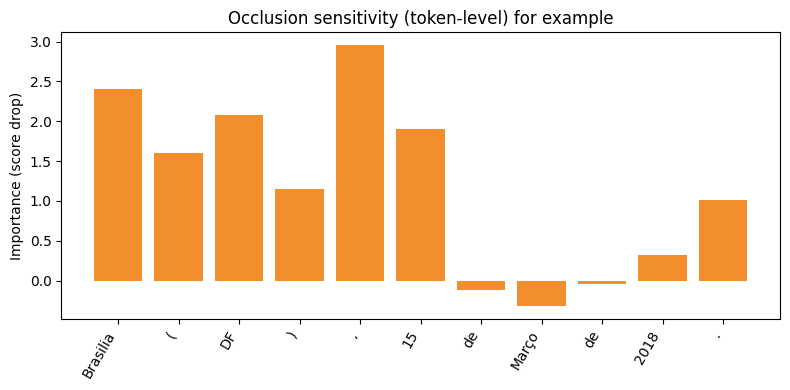

In [91]:
tokens_for_occlusion, occlusion_scores = compute_occlusion_scores(
    example_tokens, model, tokenizer, label_list
)

plt.figure(figsize=(8, 4))
plt.bar(range(len(tokens_for_occlusion)), occlusion_scores, color="#f28e2b")
plt.xticks(range(len(tokens_for_occlusion)), tokens_for_occlusion, rotation=60, ha="right")
plt.ylabel("Importance (score drop)")
plt.title("Occlusion sensitivity (token-level) for example")
# Small negative values mean the token slightly helps the baseline score when hidden.
plt.tight_layout()
plt.show()


In [92]:
def topk_indices(scores, k=5):
    scores = np.array(scores, dtype=float)
    order = np.argsort(-scores)  # desc
    return order[:k].tolist()


def build_interpretability_summary(tokens, saliency, occlusion, ig=None, k=5):
    rows = []

    # Saliency
    sal_top = topk_indices(saliency, k=k)
    for i in sal_top:
        rows.append(
            {
                "method": "saliency",
                "token": tokens[i],
                "idx": i,
                "score": float(saliency[i]),
            }
        )

    # IG (optional)
    if ig is not None:
        ig_top = topk_indices(ig, k=k)
        for i in ig_top:
            rows.append(
                {
                    "method": "integrated_gradients",
                    "token": tokens[i],
                    "idx": i,
                    "score": float(ig[i]),
                }
            )

    # Occlusion
    occ_top = topk_indices(occlusion, k=k)
    for i in occ_top:
        rows.append(
            {
                "method": "occlusion",
                "token": tokens[i],
                "idx": i,
                "score": float(occlusion[i]),
            }
        )

    df = (
        pd.DataFrame(rows)
        .sort_values(["method", "score"], ascending=[True, False])
        .reset_index(drop=True)
    )
    return df


df_interp = build_interpretability_summary(
    tokens=example_tokens,
    saliency=saliency_scores,
    occlusion=occlusion_scores,
    ig=ig_scores if "ig_scores" in globals() and ig_scores is not None else None,
    k=6,
)

df_interp

,method,token,idx,score
0,integrated_gradients,2018,9,1.507984
1,integrated_gradients,Março,7,1.220937
2,integrated_gradients,.,10,1.004536
3,integrated_gradients,(,1,0.981562
4,integrated_gradients,",",4,0.938212
5,integrated_gradients,DF,2,0.925069
6,occlusion,",",4,2.952214
7,occlusion,Brasilia,0,2.398221
8,occlusion,DF,2,2.075781
9,occlusion,15,5,1.905782


In [93]:
def jaccard(a, b):
    a, b = set(a), set(b)
    if len(a | b) == 0:
        return 0.0
    return len(a & b) / len(a | b)


def method_top_tokens(df_interp, method, k=6):
    return df_interp[df_interp["method"] == method].head(k)["token"].tolist()


k = 6
sal_top = method_top_tokens(df_interp, "saliency", k=k)
occ_top = method_top_tokens(df_interp, "occlusion", k=k)

pairs = [
    ("saliency", "occlusion", sal_top, occ_top),
]

if "ig_scores" in globals() and ig_scores is not None:
    ig_top = method_top_tokens(df_interp, "integrated_gradients", k=k)
    pairs += [
        ("saliency", "integrated_gradients", sal_top, ig_top),
        ("occlusion", "integrated_gradients", occ_top, ig_top),
    ]

rows = []
for m1, m2, t1, t2 in pairs:
    rows.append(
        {
            "method_1": m1,
            "method_2": m2,
            "overlap_count": len(set(t1) & set(t2)),
            "jaccard": jaccard(t1, t2),
            "top_1": t1,
            "top_2": t2,
        }
    )

df_consistency = pd.DataFrame(rows)
df_consistency

,method_1,method_2,overlap_count,jaccard,top_1,top_2
0,saliency,occlusion,4,0.500000,"[Brasilia, 2018, Março, (, DF, 15]","[,, Brasilia, DF, 15, (, )]"
1,saliency,integrated_gradients,4,0.500000,"[Brasilia, 2018, Março, (, DF, 15]","[2018, Março, ., (, ,, DF]"
2,occlusion,integrated_gradients,3,0.333333,"[,, Brasilia, DF, 15, (, )]","[2018, Março, ., (, ,, DF]"


### Interpretation of Occlusion Sensitivity

The occlusion experiment on the qualitative example reveals that the model relies heavily on the core tokens of each entity, with strong drops in prediction confidence when tokens such as “Brasília”, “DF”, “15”, and key punctuation marks are masked. These elements serve as anchors in legal text: proper nouns defining locations, numbers marking temporal expressions, and structural delimiters that signal the boundaries of legal entities.

High-frequency functional tokens, such as “de”, produce near-zero or even slightly negative impact when removed. This indicates that such tokens contribute little meaningful signal, and the model has learned to ignore syntactic filler while focusing on semantic anchors.

This is still a single example; the next section aggregates evidence across the validation subset.


## 8. Dataset-level evidence: EntityFocus@k

We quantify whether the model’s importance scores land on gold entities across the validation subset. `EntityFocus@k` measures the share of the top-k tokens (by importance) that are entity tokens. `EntityRatio` is the fraction of entity tokens in the sentence. `Lift@k` compares the two (values > 1 mean the model highlights entities more than expected by their frequency). Sentences without entities are skipped. Occlusion is run on a small subset (10 examples) as a causal cross-check.


In [94]:
def compute_entity_focus_metrics(tokens, ner_tags, scores, k, non_entity_id):
    scores = np.asarray(scores, dtype=float)
    n = len(scores)

    # se importance_fn truncou, corta tokens/tags para avaliar o MESMO trecho
    tokens = tokens[:n]
    ner_tags = ner_tags[:n]
    if n == 0:
        return np.nan, np.nan, np.nan

    entity_mask = np.asarray([t != non_entity_id for t in ner_tags], dtype=bool)
    entity_ratio = float(entity_mask.mean())

    actual_k = int(min(k, n))
    top_idx = (
        np.argsort(-scores)[:actual_k] if actual_k > 0 else np.array([], dtype=int)
    )

    focus = float(entity_mask[top_idx].mean()) if actual_k > 0 else np.nan
    lift = focus / entity_ratio if entity_ratio > 0 else np.nan
    return focus, entity_ratio, lift


def compute_entity_focus_dataset(
    dataset,
    importance_fn,
    k=6,
    max_examples=200,
    non_entity_id=0,
    skip_no_entity=True,
):
    rows, picked = [], 0

    for idx in range(len(dataset)):
        if picked >= max_examples:
            break

        ex = dataset[idx]
        tokens = ex["tokens"]
        tags = ex["ner_tags"]

        scores = importance_fn(tokens)
        scores = np.asarray(scores, dtype=float)
        if len(scores) == 0:
            continue

        # entity ratio no trecho avaliado (alinhado com scores)
        tags_eval = tags[: len(scores)]
        entity_ratio = np.mean([t != non_entity_id for t in tags_eval])
        if skip_no_entity and entity_ratio == 0:
            continue

        focus, entity_ratio2, lift = compute_entity_focus_metrics(
            tokens, tags, scores, k=k, non_entity_id=non_entity_id
        )

        rows.append(
            {
                "idx": idx,
                "len_eval": len(scores),
                "entity_ratio_in_eval": float(entity_ratio2),
                "entity_focus_at_k": float(focus),
                "lift_at_k": float(lift),
            }
        )
        picked += 1

    return pd.DataFrame(rows)


def make_occlusion_importance_fn(
    model, tokenizer, label_list, max_tokens_for_occlusion=40
):
    """
    Retorna uma importance_fn(tokens) que:
      - só roda occlusion se len(tokens) <= max_tokens_for_occlusion
      - caso contrário, retorna [] (pra ser skipado)
    """

    def fn(tokens):
        if len(tokens) > max_tokens_for_occlusion:
            return []
        return compute_occlusion_scores(
            tokens, model, tokenizer, label_list, return_tokens=False
        )

    return fn


In [96]:
focus_k = 6

# ✅ Saliency (roda em bastante exemplos)
df_entity_focus_sal = compute_entity_focus_dataset(
    lener["validation"],
    importance_fn=lambda toks: saliency_importance(toks, model, tokenizer),
    k=focus_k,
    max_examples=200,
    non_entity_id=label2id["O"],
    skip_no_entity=True,
)

# ✅ Occlusion (roda só em frases curtas)
occ_fn = make_occlusion_importance_fn(
    model, tokenizer, label_list, max_tokens_for_occlusion=40
)
df_entity_focus_occ = compute_entity_focus_dataset(
    lener["validation"],
    importance_fn=occ_fn,
    k=focus_k,
    max_examples=30,  # 30 exemplos COM entidade e curtos
    non_entity_id=label2id["O"],
    skip_no_entity=True,
)

[saliency] n=200
        entity_focus_at_k  lift_at_k
mean             0.464333   2.582794
median           0.366667   2.200000
std              0.303277   2.010784
[occlusion] n=30
        entity_focus_at_k  lift_at_k
mean             0.488889   1.481481
median           0.500000   1.666667
std              0.306173   0.642213


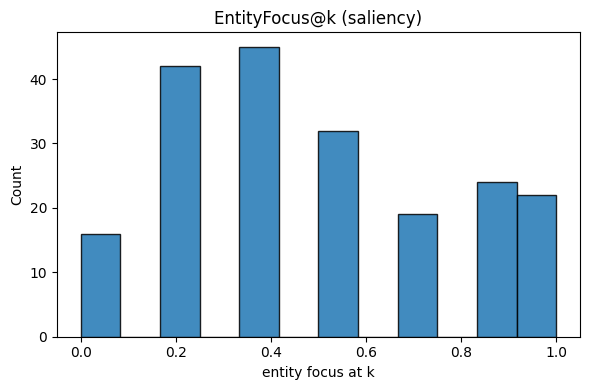

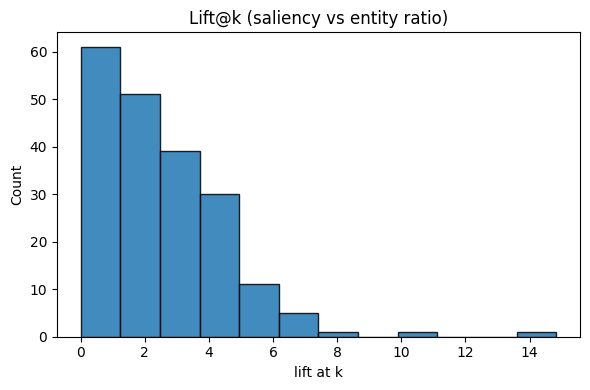

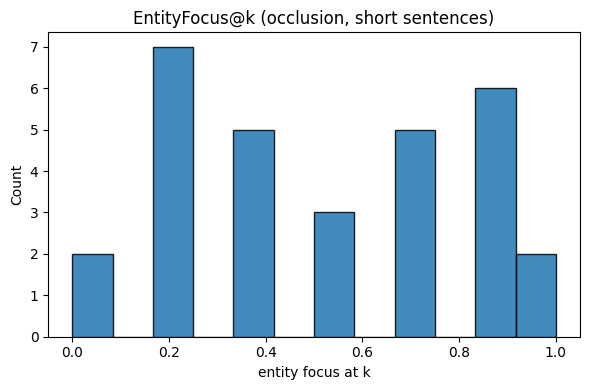

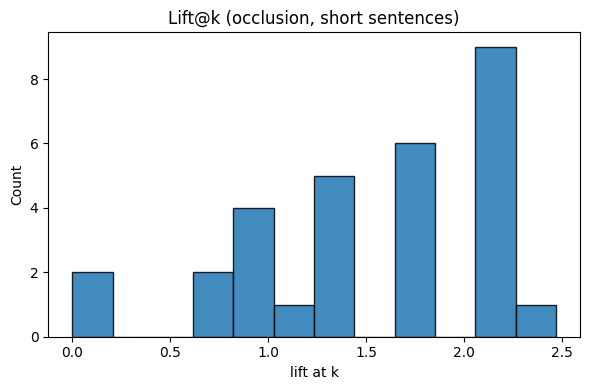

In [98]:
def summarize_focus(df, name):
    if df.empty:
        print(f"[{name}] empty")
        return
    stats = df[["entity_focus_at_k", "lift_at_k"]].agg(["mean", "median", "std"])
    print(f"[{name}] n={len(df)}")
    print(stats)


def plot_focus_distribution(df, column, title, bins=12):
    plt.figure(figsize=(6, 4))
    plt.hist(df[column].dropna(), bins=bins, edgecolor="black", alpha=0.85)
    plt.xlabel(column.replace("_", " "))
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


focus_k = 6

# Saliency em 200 exemplos
df_sal = compute_entity_focus_dataset(
    lener["validation"],
    importance_fn=lambda toks: saliency_importance(toks, model, tokenizer),
    k=focus_k,
    max_examples=200,
    non_entity_id=label2id["O"],
)

# Occlusion só em frases curtas
occ_fn = make_occlusion_importance_fn(
    model,
    tokenizer,
    label_list, 
    max_tokens_for_occlusion=40,
)

df_occ = compute_entity_focus_dataset(
    lener["validation"],
    importance_fn=occ_fn,
    k=focus_k,
    max_examples=30,
    non_entity_id=label2id["O"],
)

summarize_focus(df_sal, "saliency")
summarize_focus(df_occ, "occlusion")

plot_focus_distribution(df_sal, "entity_focus_at_k", "EntityFocus@k (saliency)")
plot_focus_distribution(df_sal, "lift_at_k", "Lift@k (saliency vs entity ratio)")

if not df_occ.empty:
    plot_focus_distribution(
        df_occ, "entity_focus_at_k", "EntityFocus@k (occlusion, short sentences)"
    )
    plot_focus_distribution(df_occ, "lift_at_k", "Lift@k (occlusion, short sentences)")

### Quantitative findings

We moved from anecdotal examples to a dataset-level check using **EntityFocus@6** (fraction of entity tokens among the top-6 most important tokens) and **Lift@6** (EntityFocus@6 divided by the entity-token ratio in the same evaluated text span).

* **Saliency (n=200 validation sentences with at least one entity, k=6)**
  *EntityFocus@6*: **mean 0.46**, median **0.37**, std **0.30**
  *Lift@6*: **mean 2.58**, median **2.20**, std **2.01**
* **Occlusion (short sentences only; n=30, k=6)**
  *EntityFocus@6*: **mean 0.49**, median **0.50**, std **0.31**
  *Lift@6*: **mean 1.48**, median **1.67**, std **0.64**
* Interpretation: in aggregate, the model’s top-k “importance mass” is **more concentrated on entity tokens than expected by chance**, especially under saliency (higher lift). Occlusion—being a more intervention-like test—still shows above-baseline emphasis on entity tokens, but with a more moderate lift.
* Caveat: importance can also land on punctuation or boundary markers (especially in shorter legal snippets), and both methods show substantial variance. This motivates reporting distributions (histograms) rather than relying only on means.

---

## **9. Qualitative illustration summary**

Across attention and attribution methods on the selected validation example, the model shows a coherent reliance pattern:

* **Predicted labels** correctly identify *“Brasília ( DF )”* as **LOCAL** and *“15 de Março de 2018”* as **TEMPO**.
* **Attention (word-level)** highlights entity head tokens (e.g., “Brasília”, “DF”, “2018”) and also assigns noticeable weight to punctuation that marks entity boundaries.
* **Saliency** assigns the highest scores to the entity anchors (*“Brasília”, “2018”, “Março”, “DF”*), indicating that small perturbations to these tokens would disproportionately change the model’s output.
* **Occlusion sensitivity** supports the same narrative: masking anchor tokens yields the largest drops in the model’s proxy confidence, whereas function words (e.g., “de”) tend to matter less.

Overall, the example-level behavior matches the dataset-level trend: **important tokens are frequently entity-defining anchors**, with some attention/importance also allocated to boundary punctuation.

---

## **10. Link with Robustness Results**

The interpretability results help explain the robustness behavior observed earlier:

* **Character noise** can heavily degrade performance because the model relies on **exact surface forms** of anchor tokens (e.g., “Brasília”, “DF”, dates). Corrupting a character often alters subword segmentation and destroys cues that saliency/attention identify as critical.
* **Masking** is most harmful when it hits anchor tokens—consistent with large saliency scores and large occlusion drops for those positions.
* **Word insertion** can cause sharp degradation because NER depends on local ordering and formatting cues; inserted tokens shift boundaries and disrupt patterns the model learned from legal-style text.
* **Accent removal** or mild **synonym substitution** may be less damaging when they preserve overall structure and recognizable anchors, aligning with attention focusing on stable “reference points” rather than every context token.
* **Occlusion results** reinforce the key message: removing high-importance entity anchors is far more disruptive than removing syntactic fillers.

---

## **11. Conclusion**

* Using dataset-level metrics on the validation split, **EntityFocus@6** shows that the model’s top-k importance is biased toward entity tokens:

  * **Saliency (n=200):** mean focus **0.46**, mean lift **2.58**
  * **Occlusion on short sentences (n=30):** mean focus **0.49**, mean lift **1.48**
* Qualitative attention + attribution plots are consistent with these findings: **entity anchors and boundary punctuation** dominate the attribution patterns, while most filler tokens contribute less.
* This explains key robustness weaknesses (e.g., character noise and insertions) and suggests mitigation via **data augmentation targeting anchor corruption** (typos, accent removal, near-miss strings) and robustness-oriented training to reduce over-reliance on brittle surface forms.
